# Unit 5 - Financial Planning - Alternate Solution

In [5]:
# Initial imports
import os
import requests
import pandas as pd
# from dotenv import load_dotenv
# import alpaca_trade_api as tradeapi

from datetime import datetime                   # Import datetime function
from datetime import timedelta                  # Import timedelta function

from NewForecastTools import MCSimulation       # Import Geometric Brownian Motion (GBM) Monte Carlo simulation model

import json
import seaborn as sns

%matplotlib inline

# Initialise Global Variables

In [6]:
# Load .env enviroment variables - these are critical so if any error occurs then stop the script
# If the .env file can't be loaded then print a useful error message and end the script
if not load_dotenv():                                                                                        # Couldn't load the .env file?
    print("Error: could not load .env file. Refer to README.md for instructions on how to set this up.")     #   Print an error message
    exit()                                                                                                   #   Stop the script from proceeding

In [11]:
# Initialise variables needed for the Alpaca Markets API
# Note: The ALPACA_API_KEY and ALPACA_SECRET_KEY are critical for accessing the necessary data. For security reasons these are not initialised in the clear and only fetched from
# the .env file. If we can't fetch them then we warn the user and stop the script.

# Try getting the ALPACA_API_KEY
alpaca_api_key = os.environ.get('ALPACA_API_KEY')        # Fetch the api key from the .env file
if not (alpaca_api_key):                                 # If we couldn't read a valid value...
    print("Error: 'ALPACA_API_KEY' has not been configured correctly in your .env file. Refer to README.md for instructions on how to set this up.")     #    print an error message
    exit()                                               #   Stop the script from proceeding
    
alpaca_secret_key = os.environ.get('ALPACA_SECRET_KEY')  # Fetch the secret key from the .env file
if not (alpaca_secret_key):                              # If we couldn't read a valid value..
    print("Error: 'ALPACA_SECRET_KEY' has not been configured correctly in your .env file. Refer to README.md for instructions on how to set this up.")     #    print an error message
    exit()                                               #   Stop the script from proceeding

# The ALPACA_BASE_URL is not as critical and can be shown in the "clear". We default to the paper-trading environment if it is not configured in the .env file.
alpaca_base_url = os.environ.get('ALPACA_BASE_URL')                                                       # Try to fetch Alpaca's base url from the .env file. 
if not(alpaca_base_url):                                                                                  # If the base url isn't configured in the .env file then...
    alpaca_base_url = "https://paper-api.alpaca.markets"                                                  #   default Alpaca's base url to the paper trading environment, and 
    print(f"Warning: ALPACA_BASE_URL configuration not found in .env file. Defaulting to '{alpaca_base_url}'")     #   print a warning for the user they are using the paper trading environment

alpaca_api_version = "v2"                                # Set the Alpaca API version we will use

# Create the Alpaca API object
alpaca_api = tradeapi.REST(key_id=alpaca_api_key, secret_key=alpaca_secret_key, base_url=alpaca_base_url, api_version=alpaca_api_version)


In [12]:
# Check status of the Alpaca trading account
account = alpaca_api.get_account()            # Get details of the account (code provided by Alpaca Trade API)
account_status = account.status               # Grab the account status    (code provided by Alpaca Trade API)

print(f"Info: Your Alpaca account status is [{account_status}]")  # Show the current account status
if not (account_status == "ACTIVE"):                             # If the account status is not Active                            
    print("Error: Your account status is not Active. Please activate your account or check your Alpaca keys are correct.")   # Show the error messsage, and a helpful way to resolve
    exit()                                                                                                                   # Stop the script from proceeding

Info: Your Alpaca account status is [ACTIVE]


In [ ]:
# Initialise general global variables

In [67]:
# Intialise the makeup of the portfolio.
# *** Nice to have: read the portfolio from a csv or database or a GUI (which then save to a csv or database)

# Column names for the portfolio dataframe
column_names =     ["Ticker Code", "Qty Owned", "Buy Price", "Purchase Date"]       # Ticker Code, Quantity of Shares Owned, Original Purchase Price per share, Purchase Date

portfolio_list = [
# Set your portfolio contents here...
#                  ** Ticker **  Qty   **  Buy   **  Purchase Date ** 
#                  ** Code   **  Owned **  Price **  YYYY-MM-DD    **
                   [ "V",       123.0,    44.32,    "2021-11-10"   ],
                   [ "USB",      59.0,    43.11,    "2021-11-15"   ],
                   [ "USB",      90.0,    42.67,    "2021-11-16"   ],
                   [ "AXP",     234.0,    12.43,    "2020-07-22"   ],
                   [ "MA",      115.0,    11.01,    "2020-08-25"   ],
                   [ "MA",      112.0,    12.15,    "2020-08-28"   ]
]

# Initialise the portfolio composition.
portfolio_df = pd.DataFrame(portfolio_list, columns=column_names) # Note we may have multiple entried for the same stock so we can't index the Ticker Code.

currency_code = "USD"            # Set the default currency code which we will be working with.  *** Nice to have: include multi-currency support and currency conversion.
base_market_index_code = "SPY"   # Set the market index code to be used for comparative purposes against the portfolio.  *** Nice to have: user selects from a list

In [68]:
portfolio_df

,Ticker Code,Qty Owned,Buy Price,Purchase Date
0,V,123.0,44.32,2021-11-10
1,USB,59.0,43.11,2021-11-15
2,USB,90.0,42.67,2021-11-16
3,AXP,234.0,12.43,2020-07-22
4,MA,115.0,11.01,2020-08-25
5,MA,112.0,12.15,2020-08-28


In [138]:
# Create a ticker list without duplicates from our portofolio
ticker_list = portfolio_df["Ticker Code"].unique()
ticker_list

array(['V', 'USB', 'AXP', 'MA'], dtype=object)

In [153]:
# Group and add up the total of each stock of the same code
aggregated_qty = portfolio_df[["Ticker Code","Qty Owned"]].groupby("Ticker Code").sum()
aggregated_qty

,Qty Owned
Ticker Code,
AXP,234.0
MA,227.0
USB,149.0
V,123.0


In [154]:
# Workout the average buy price of each stock
average_buy_price = portfolio_df[["Ticker Code","Buy Price"]].groupby("Ticker Code").mean()
average_buy_price.rename(columns={"Buy Price": "Avg Buy Price"}, inplace=True) 
average_buy_price

,Avg Buy Price
Ticker Code,
AXP,12.43
MA,11.58
USB,42.89
V,44.32


In [155]:
# Create a consolidated dataframe of the total of each stock owned and the average buy price
consolidated_df = pd.concat([aggregated_qty, average_buy_price], axis=1)
consolidated_df

,Qty Owned,Avg Buy Price
Ticker Code,,
AXP,234.0,12.43
MA,227.0,11.58
USB,149.0,42.89
V,123.0,44.32


In [ ]:
# determine current value

In [ ]:
# Initialise variables needed for... Kay 

In [ ]:
# Initialise variables needed for... Naz
df_portfolio = portfolio
period_for_simulation = time_frame
# weights = ??


# Function Definitions

## get_latest_price

In [192]:
# Function: get_latest_price ( ticker_list )
# Purpose: Fetches the latest (one single day's worth) of trading data for the specified stock(s).
# Inputs:
#    ticker_list: list of ticker symbols e.g. ["ABC", "DEF", "GHI"]
# Outputs:
#   returns a data frame as per alpaca_api.get_bars format

def get_latest_price ( tickers ):

    # Set timeframe to "1Day" for Alpaca API
    timeframe = "1Day"

    # Loop until we find valid trading data or abort after max_attempts attempts
    # Initialise variables
    attempt = 0                       # Initialise the attempt count
    max_attempts = 10                 # Initialise the maximum number of attempts after which we give up
    df_portfolio = pd.DataFrame()     # Intialise the dataframe

    while (attempt < max_attempts) and (len(df_portfolio) == 0):    # Loop until we find an active trading day or abort after the max attempts
        if attempt == 0:
            date_to_fetch = pd.Timestamp.now( tz="America/New_York").normalize()            # Get today's date on the first iteration of the loop
        else:
            date_to_fetch = date_to_fetch + timedelta(days=-1)                              # Decrement the date

        date_to_fetch_iso = date_to_fetch.isoformat()                                       # Convert the date to iso format needed by alpaca_api
        attempt += 1                                                                        # Increment the attempt counter

        # Get current closing prices for SPY and AGG and transform the function's response to a Pandas DataFrame
        df_portfolio = alpaca_api.get_bars( tickers, timeframe, start = date_to_fetch_iso, end = date_to_fetch_iso ).df    # Get the ticker data from alpaca_api

        if len(df_portfolio) == 0:                                                          # If no data returned...
            print(f"Warning: No price information available for {date_to_fetch_iso}")                #   show a warning message with the date

    if len(df_portfolio) == 0:                                                              # Once we exit the loop check if we managed to get ticker data, if not
        print("Error: Could not find data after {max_attempts} attempts" )                         #   show a warning message with the number of max attempts tried
#    else:
#        display(df_portfolio.head())    # Display sample data                                 # DEBUG show the sample data    
    return df_portfolio

## get_stock_history

In [197]:
# Function: get_stock_history ( ticker_list, start_date, end_date )
# Purpose: Fetches the historical trading data for the specified stock(s).
# Inputs:
#   ticker_list: list of ticker symbols e.g. ["ABC", "DEF", "GHI"]
#   start_date: oldest date in the data range to fetch
#   end_date:   most recent date in the data range to fetch
# Outputs:
#   returns a data frame of historical trading data as per alpaca_api.get_bars format

def get_stock_history ( ticker_list, start_date, end_date ):
    timeframe = "1Day"
    return alpaca_api.get_bars( ticker_list, timeframe, start = start_date, end = end_date ).df

## Function 3

In [ ]:
# Function: my_function3 (function name)
# Purpose: adds 1 to the input parameter (What it does)
# Inputs: p1 a number which will be incremented (Name of parameters and their purpose)
# Outputs: the p1 parameter incredmented by 1 (What it returns, if applicable)

def my_function3 ( p1 ):
    # 
    return p1 + 1

## Add more as required

# Main Code Section

# Initialise environment variables

In [ ]:
# Call function


## Initialise / load the Portfolio Composition

In [ ]:
# Call function

# output: portfolio

## Show Current Value of the Portfolio   
Fetch the latest stock prices for the stocks in the portfolio and present a table and a pie chart showing the portfolio composition and current value

In [142]:
# Show the list of ticker codes in the portfolio
ticker_list

array(['V', 'USB', 'AXP', 'MA'], dtype=object)

In [143]:
# Get current prices of each stock in the portfolio
current_prices = get_latest_price ( ticker_list ).set_index("symbol")

current_prices.head(10)

,close,high,low,trade_count,open,volume,vwap
symbol,,,,,,,
AXP,152.6340,153.2575,151.205,19805,152.37,1035012,152.628057
MA,400.5169,404.4300,398.780,23212,400.24,717641,402.202520
USB,32.4550,32.7700,31.950,47546,32.58,5444186,32.504792
V,238.7400,240.7100,238.330,47130,239.00,2400872,239.616144


In [156]:
consolidated_df

,Qty Owned,Avg Buy Price
Ticker Code,,
AXP,234.0,12.43
MA,227.0,11.58
USB,149.0,42.89
V,123.0,44.32


In [176]:
# Calculate current value, original purchase cost, and profit in new datafrome
portfolio_current_stats = consolidated_df.copy() # Create a copy of the dataframe as we are adding columns that may not be useful in other scenarions
portfolio_current_stats.index.names = ['symbol'] # Rename the index to match the Alpaca price list dataframe 

# Add new columns and initialise
portfolio_current_stats['Current Value'] = 0.0   # Add current value column and initialise values to 0
portfolio_current_stats['Purchase Value'] = 0.0  # Add purchase value column and initialise values to 0
portfolio_current_stats['Profit'] = 0.0          # Add profit column and initialise values to 0

# Perform calculations
portfolio_current_stats['Current Value'] = current_prices['close'] * portfolio_current_stats['Qty Owned']                        # Calculate the Current value by multiplying the close price by the quantity of each share owned 
portfolio_current_stats['Purchase Value'] = portfolio_current_stats['Avg Buy Price'] * portfolio_current_stats['Qty Owned']      # Calculate the Purchase value by multiplying the original (average) buy price by the quantity of each share owned
portfolio_current_stats['Profit'] = portfolio_current_stats['Current Value'] - portfolio_current_stats['Purchase Value']         # Calculate the Profit subtracting the current value from the original cost
portfolio_current_stats

,Qty Owned,Avg Buy Price,Current Value,Purchase Value,Profit
symbol,,,,,
AXP,234.0,12.43,35716.3560,2908.62,32807.7360
MA,227.0,11.58,90917.3363,2628.66,88288.6763
USB,149.0,42.89,4835.7950,6390.61,-1554.8150
V,123.0,44.32,29365.0200,5451.36,23913.6600


In [177]:
# Determine the current total value and total profit / loss

total_portfolio_value = portfolio_current_stats["Current Value"].sum()
total_portfolio_profit = portfolio_current_stats["Profit"].sum()
print(f"Info: Portfolio's current total value is       ${total_portfolio_value:0,.2f}")
print(f"Info: Portfolio's current total profit/loss is ${total_portfolio_profit:0,.2f}")

Info: Portfolio's current total value is       $160,834.51
Info: Portfolio's current total profit/loss is $143,455.26


In [ ]:
df_savings = pd.DataFrame([total_crypto_value, total_shares_value], index=["crypto", "shares"], columns=["amount"])

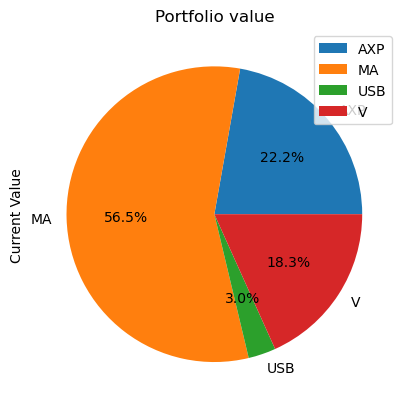

In [190]:
# Plot porfolio value into a pie chart
fig1_portfolio_value_pie_chart  = portfolio_current_stats.plot.pie( y="Current Value", autopct = "%1.1f%%" , title = "Portfolio value" )

# User Setting - Desired Portfolio Weighting
Set the Desired Weighting as required.   
Note the order in the list below corresponds to the `symbol` order above 

In [167]:
# Set the required portolio weighting
desired_weighting = [1/4, 1/4, 1/4, 1/4]
desired_weighting

[0.25, 0.25, 0.25, 0.25]

In [158]:
consolidated_df

,Qty Owned,Avg Buy Price
Ticker Code,,
AXP,234.0,12.43
MA,227.0,11.58
USB,149.0,42.89
V,123.0,44.32


# Determine current portfolio weighting

In [188]:
# Determine portfolio weighting in each stock/ticker. (calcualte from first step) Kay
# Determine the current weighting of each stock
portfolio_current_stats['Weighting'] = 0.0   # Add a new column for weighting

portfolio_current_stats['Weighting'] = portfolio_current_stats['Current Value'] / total_portfolio_value         # Calculate thestock weighting as a percentage of the total porfolio value
portfolio_current_stats['Weighting'] # Show the results

symbol
AXP    0.222069
MA     0.565285
USB    0.030067
V      0.182579
Name: Weighting, dtype: float64

# Allow User to Select an Investment Timeframe   
This will be used to determine period of data to fetch, allow investor to choose comparable timeframe. ( dic or array or menu as fixed option, nice to have will be GUI slider or Menu) Kay

In [ ]:
# Call functions

# Output: time_frame     # time frame to fetch

# API fetches Ticker data based on timeframe. Bruno
Input: portfolio, time_frame
Output: 


In [202]:
# Get all historical trading data for all stocks
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

for symbol in ticker_list:
    single_stock_historical_data_df = get_stock_history( symbol, start_date, end_date )
    display(single_stock_historical_data_df.head())

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-05-02 04:00:00+00:00,78.46,78.47,77.16,56825,77.81,8222959,77.980670
2016-05-03 04:00:00+00:00,77.19,78.36,76.93,56559,77.43,8414532,77.316374
2016-05-04 04:00:00+00:00,77.07,77.38,76.35,55830,76.56,9660908,76.851690
2016-05-05 04:00:00+00:00,77.36,77.70,77.01,41981,77.15,6367069,77.312123
2016-05-06 04:00:00+00:00,77.72,77.80,76.78,44685,77.23,6536396,77.364514


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-05-02 04:00:00+00:00,42.97,43.160,42.62,45220,43.02,9217760,42.976107
2016-05-03 04:00:00+00:00,42.50,42.555,42.00,44343,42.33,6871777,42.362663
2016-05-04 04:00:00+00:00,41.72,42.280,41.39,55641,42.04,9255193,41.697421
2016-05-05 04:00:00+00:00,41.65,42.000,41.54,38951,41.82,6306395,41.679875
2016-05-06 04:00:00+00:00,41.78,41.810,41.36,32393,41.41,5619466,41.651912


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-05-02 04:00:00+00:00,65.68,66.05,65.175,27086,65.58,4490540,65.730669
2016-05-03 04:00:00+00:00,64.85,65.05,64.330,31455,65.03,5041712,64.736683
2016-05-04 04:00:00+00:00,64.26,64.75,63.830,29849,64.13,5252943,64.187752
2016-05-05 04:00:00+00:00,63.92,64.72,63.790,25246,64.46,4228500,64.121166
2016-05-06 04:00:00+00:00,64.51,64.71,63.450,22348,63.76,3873025,64.320592


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-05-02 04:00:00+00:00,97.77,97.94,96.49,33212,97.15,3979442,97.388261
2016-05-03 04:00:00+00:00,96.45,97.54,95.92,30770,97.01,3682600,96.426451
2016-05-04 04:00:00+00:00,96.25,96.39,95.23,27100,95.72,3413136,95.851666
2016-05-05 04:00:00+00:00,96.19,96.83,95.96,27166,96.34,2993477,96.285054
2016-05-06 04:00:00+00:00,96.68,96.76,95.65,18874,95.80,2187776,96.276710


In [203]:
# Get all historical trading data for all stocks
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

all_historical_data_df = get_stock_history( ticker_list, start_date, end_date )
all_historical_data_df

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2016-05-02 04:00:00+00:00,65.68,66.05,65.1750,27086,65.58,4490540,65.730669,AXP
2016-05-03 04:00:00+00:00,64.85,65.05,64.3300,31455,65.03,5041712,64.736683,AXP
2016-05-04 04:00:00+00:00,64.26,64.75,63.8300,29849,64.13,5252943,64.187752,AXP
2016-05-05 04:00:00+00:00,63.92,64.72,63.7900,25246,64.46,4228500,64.121166,AXP
2016-05-06 04:00:00+00:00,64.51,64.71,63.4500,22348,63.76,3873025,64.320592,AXP
...,...,...,...,...,...,...,...,...
2021-04-26 04:00:00+00:00,230.34,232.95,229.5200,75343,230.77,6629698,230.678793,V
2021-04-27 04:00:00+00:00,229.91,231.16,228.9850,85668,231.03,7172084,229.936531,V
2021-04-28 04:00:00+00:00,233.45,236.27,230.6748,113830,230.95,10775689,233.855194,V


# Hvplot
line graph comparing portfolio result v S&P500 or any other available index (Research). Kay Naz bruno 

In [ ]:
# Call function

---

# Calculate portfolio beta, sharp ratio v market.( function) (hv plots) Naz


In [ ]:
# Convert the index to datetime format
df_portfolio.index = pd.to_datetime(df_portfolio.index)
# Extract just the date for the entire index
df_portfolio.index = df_portfolio.index.date

In [ ]:
# Calculate and plot the correlation
correlation_portoflio = df_portfolio.corr()
correlation_portfolio
# Display de correlation matrix
sns.heatmap(correlation_portfolion, vmin=-1, vmax=1)


df_portfolio.pct.change()
# Set weights
weights = variable_from_above

# Calculate portfolio return
custom_port_daily_returns_dot = df_portfolio.dot(weights)
# Display sample data
custom_port_daily_returns_dot.name = "Portfolio Returns"


In [ ]:
# Beta of portfolio
covariance_df = pd.concat([custom_port_daily_returns_dot,df_portfolio], axis=1, join='inner')
covariance_df = covariance_df.drop(columns=[], inplace=True)
covariance = covariance_df["Portfolio Returns"].cov(covariance_df["Benchmark"])

variance = covariance_df["Benchmark"].var()

portfolio_beta = covariance/variance
    
    

In [ ]:
# Sharp Ratio
sharp_ratio = (df.mean()*252)/(df.std()*np.sqrt(252))
sharp_ratio.sort_values(ascending=False,inplace=True)
sharp_ratio

# Calculate accumulated returns (cumprod etc) Naz

In [ ]:
initial_investment = portfolio_value_as_per_above

cumulative_return = (1+custom_port_daily_returns_dot).cumprod()
# Plot cumulative returns
cumulative_return.hvplot(figsize = (20,10), title= '');

cumulative_profits = initial_investment * cumulative_return
cumulative_profits.hvplot(figsize = (20,10), 
                          title= f'Return over {variable_based_on_above_selection} period'
                          
                          
                          
                          
                          

In [ ]:
# ROI = (Current Value of Investment - Cost of Investment) / Cost of Investment
current_value = as_per_above

roi = (current_value - initial_investment) / initial_investment
roi_pct = roi * 100
print(f"ROI for an initial investment of ${initial_investment} "
      f"now priced at ${current_price} "
      f"is {roi} or {roi_pct}%")

# Monte Carlo Simulation

In [ ]:
# Monte carlo data frame
# Reorganize the DataFrame
# Separate ticker data
Ticker_1 = df_ticker[df_ticker["symbol"]=="x"].drop("symbol", axis=1)
Ticker_2 = df_ticker[df_ticker["symbol"]=="x"].drop("symbol", axis=1)
Ticker_3 = df_ticker[df_ticker["symbol"]=="x"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_monte_sim = pd.concat([Ticker_1, Ticker_2, Ticker_3], axis=1, keys=["x","x","x"])

# Display sample data
df_monte_sim.head()

In [ ]:
#Initialising Monte Carlo Simulation:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_return = MCSimulation(portfolio_data=df_monte_carlo.drop(columns="Benchmark",
                            weights=[calculated_above],
                            num_simulation=500,
                            num_trading_days=252*5)
# Printing the simulation input data
MC_30_return.portfolio_data.head()

# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_return.calc_cumulative_return()


In [ ]:
#Desired_weigting = 